In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import theano.tensor as tt
import math

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
D:\Anaconda2\envs\py36\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
D:\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import

In [2]:
hosp = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
deaths = [0, 18, 8, 46, 8, 13, 9, 31, 14, 8, 29, 24]
total = [47, 148, 119, 810, 211, 196, 148, 215, 207, 97, 256, 360]
cols = ["R", "N"]
surgical_data = pd.DataFrame(columns = cols)
surgical_data["R"] = deaths
surgical_data["N"] = total

In [3]:
surgical_data

,R,N
0,0,47
1,18,148
2,8,119
3,46,810
4,8,211
5,13,196
6,9,148
7,31,215
8,14,207
9,8,97


In [4]:
N = len(surgical_data)
index = [0,1,2,3,4,5,6,7,8,9,10,11]
print(index[0])


0


In [5]:
with pm.Model() as surgical_model:
    mu_b = pm.Normal('mu', mu=0, sd = 1e-6)
    tau_b = pm.Gamma('tau', 0.001, 0.001)
    #sd_b = pm.Deterministic('sd_b', 1/pm.math.sqrt(tau_b))
    b = pm.Normal('b', mu=mu_b, tau= tau_b, shape=N)
    prob = pm.Deterministic('prob', pm.math.invlogit(b[index]))
    r = pm.Binomial('r', p = prob[index], n = total, observed = deaths)
    

In [6]:
with surgical_model:
    #computing approximate posterior using VI
    approx=pm.fit()
    #sampling from approximate posterior
    surgical_trace=approx.sample(500)

Average Loss = 7.9679e+09: 100%|████████████████████████████████████████████████| 10000/10000 [01:31<00:00, 109.69it/s]
Finished [100%]: Average Loss = 7.9713e+09


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000020DED565A90>,
      dtype=object)

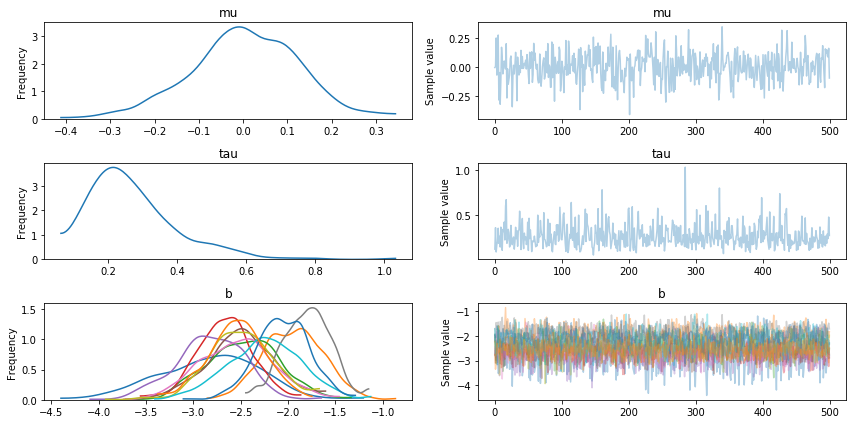

In [7]:
pm.traceplot(surgical_trace, varnames=['mu', 'tau', 'b'])

In [8]:
pm.summary(surgical_trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
mu,0.001809,0.122210,0.005566,-0.229191,0.255260
b__0,-2.828139,0.535772,0.025202,-3.915015,-1.882699
b__1,-1.945931,0.312724,0.013690,-2.485770,-1.307974
b__2,-2.469803,0.377402,0.016655,-3.192778,-1.783489
b__3,-2.671661,0.290273,0.012797,-3.235525,-2.104185
b__4,-2.829364,0.356583,0.015184,-3.533014,-2.170305
b__5,-2.506795,0.358537,0.015903,-3.190492,-1.754122
b__6,-2.545087,0.387021,0.015786,-3.324206,-1.831911
b__7,-1.798878,0.246650,0.010758,-2.361627,-1.399865
b__8,-2.506229,0.339176,0.015758,-3.166065,-1.894636


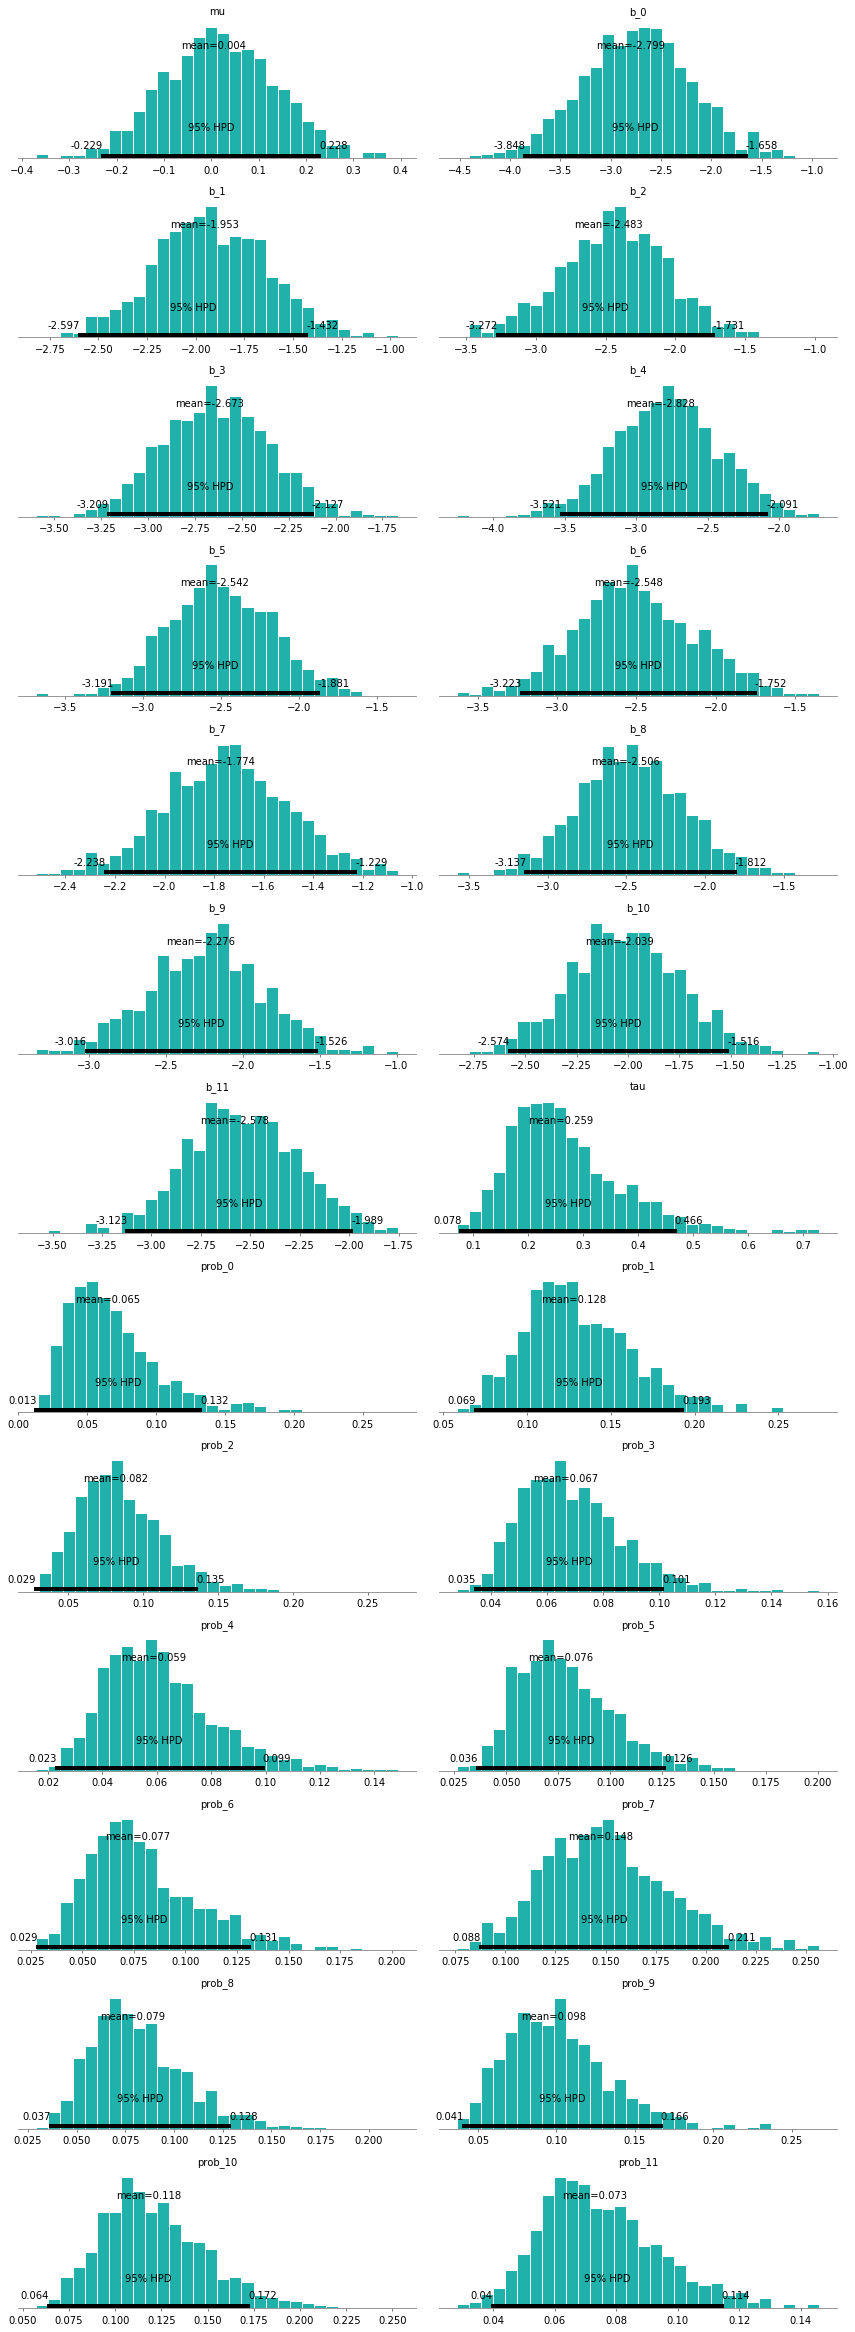

In [9]:
pm.plot_posterior(approx.sample(1000), color='LightSeaGreen');

In [33]:
#Implementation of  VI
import numpy as np
import math
from scipy.special import expit
import matplotlib.pyplot as plt

from numpy import pi as pi

#variational posterior over bi
class QPosterior():
    def __init__(self,mu,sigma):
        self.mu=mu
        self.sigma=sigma
    
    def plot(self):
        b=np.linspace(-3, 3, 120)
        pdf=np.exp(-(b-self.mu)**2/2*(self.sigma)**2)/np.sqrt(2*pi*(self.sigma)**2)
        plt.plot(b,pdf)
        plt.show()
    
    def get_samples(self,n):
        return np.random.normal(self.mu,self.sigma,n)
    def get_pdf(self,b):
        return np.exp(-(b-self.mu)**2/2*(self.sigma)**2)/np.sqrt(2*pi*(self.sigma)**2)
        
class LogLikelihood():
    
    #def __init__(self):

    def nCr(self,n,r):        
        f = math.factorial
        return f(n) // f(r) // f(n-r)
    
    def logit_inv(self,x):
        return expit(x)
    def get_log_likelihood(self,N,R,b):
        
        l=1
        for n in N:
            for r in R:
                l*= (self.nCr(n,r))*(self.logit_inv(b)**r)*((1-self.logit_inv(b))**(n-r))
        return np.log(l)
        
#prior over mu
class Prior_mu():
    def __init__(self):
        self.a=0
        self.b=10**(-6)
    
    def get_samples(self,n):
        return np.random.normal(self.a,self.b,n)


#prior over tau
class Prior_tau():
    def __init__(self):
        self.a=0.001
        self.b=0.001
    
    def get_samples(self,n):
        return scipy.stats.gamma(self.a,self.b).rvs(size=n)

#marginal prior over bi  = norm(mu,tau)     
class Prior_b():
    def __init__(self):
        self.alpha=1
        self.beta=1
        
        
    def get_pdf(self,b):
        alpha=self.alpha
        beta=self.beta
        d=((np.sqrt(2*pi))*(beta+(b**2)/2)**(alpha+0.5))        
        n=(10**3*np.exp(10**6))
        print("n",n)
        print("d",d)
        pdf=n/d
        return pdf

def objective(x,N,X,Y):
    mu=x[0]
    sigma=x[1]
    q_posterior=QPosterior(mu,sigma)
    log_likelihood=LogLikelihood()
    prior=Prior_b()
    #no. of samples for montecarlo approximation of expectations = N
    #Data = X,Y
    b_samples=q_posterior.get_samples(N)
    
    #computing objective function value
    elbo=0
    kl=0
    ll=0
    for b in b_samples:
        #KL divergence between q(b) and p(b)
        t1=np.log(q_posterior.get_pdf(b))
        u=prior.get_pdf(b)
        print("u",u)
        t2=-1*np.log(u)
        kl+=t1+t2
        print("KL:",t1,t2,kl)
        #log likelihood
        ll+=log_likelihood.get_log_likelihood(X,Y,b)
        print("LL:",ll)        
    #expected KL divergence between q(b) and p(b)
    kl=kl//N
    print("Exp kl:",kl)
    #expected log likelihood
    ll=ll//N
    print("Exp ll:",ll)
    #ELBO to be maximized
    elbo=ll-kl
    print("Elbo:",elbo)
    return -1*elbo# to be mnimized


    

In [34]:
import scipy
from scipy.optimize import minimize

#computing posterior distribution

#list for posterior dist of parameter 'bi' for each hospital
posterior=[]
#for each hospital
for i in range(12):
    x0=np.array([0,1])
    #no. of samples to do monte carlo approximation
    N=100
    args=tuple((N,list([total[i]]),list([deaths[i]])))
    #print(objective(x0,*args))
    params=minimize(objective,x0,args,method='BFGS',options={'disp': True})
    mu=params[0]
    sigma=params[1]
    distribution=QPosterior(mu,sigma)
    posterior.append(distribution)
    print("Posterior distribution of b",i,":")
    distribution.plot()

n inf
d 6.7625290581804185
u inf
KL: -1.8569044734306157 -inf -inf
LL: -75.01867259211599
n inf
d 2.8540592363133865
u inf
KL: -1.0093289661316214 -inf -inf
LL: -118.64258087070912
n inf
d 6.029923278555193
u inf
KL: -1.714283471108107 -inf -inf
LL: -130.36626251349645
n inf
d 3.064409052581734
u inf
KL: -1.0622674866644408 -inf -inf
LL: -152.02655205960664
n inf
d 3.102003762481855
u inf
KL: -1.071599510768986 -inf -inf
LL: -173.3907229029978
n inf
d 3.6881022926207523
u inf
KL: -1.2125643751017499 -inf -inf
LL: -227.34609039637837
n inf
d 2.843427162044151
u inf
KL: -1.0066192999065913 -inf -inf
LL: -270.7877207665137
n inf
d 4.1868737891293275
u inf
KL: -1.3267136684679077 -inf -inf
LL: -286.78017985724205
n inf
d 6.335116221039733
u inf
KL: -1.7743622415425828 -inf -inf
LL: -359.50306934199733
n inf
d 3.0001242619473745
u inf
KL: -1.0462213124400446 -inf -inf
LL: -405.4177654241192
n inf
d 6.9502466972222905
u inf
KL: -1.8926039162291843 -inf -inf
LL: -481.4065896405816
n inf
d 2.6

KL: -1.108188572745128 -inf -inf
LL: -3264.5126421180116
n inf
d 2.7287706952507866
u inf
KL: -0.97717991144478 -inf -inf
LL: -3305.7920489813446
n inf
d 2.6012228693429176
u inf
KL: -0.9439414146390649 -inf -inf
LL: -3343.9182028005025
n inf
d 5.994890385495541
u inf
KL: -1.7073229416677236 -inf -inf
LL: -3414.717041132079
n inf
d 3.6383298343539887
u inf
KL: -1.2008993633037603 -inf -inf
LL: -3432.8857009331673
n inf
d 4.34462590235651
u inf
KL: -1.3618564804935849 -inf -inf
LL: -3492.6043783054256
n inf
d 3.432140178193514
u inf
KL: -1.1519962026008186 -inf -inf
LL: -3511.825065014154
n inf
d 2.7366936015057908
u inf
KL: -0.9792273035034509 -inf -inf
LL: -3536.9476398185348
n inf
d 5.059845740819143
u inf
KL: -1.5161591045442684 -inf -inf
LL: -3550.535902587506
Exp kl: nan
Exp ll: -36.0
Elbo: nan
n inf
d 8.492089264875371
u inf
KL: -2.17464758432841 -inf -inf
LL: -8.764538663332585
n inf
d 3.7282287684483637
u inf
KL: -1.22193053524379 -inf -inf
LL: -26.52262415492671
n inf
d 11.336

KeyboardInterrupt: 

In [ ]:
N=500
        prior_mu=Prior_mu()
        prior_tau=Prior_tau()
        mu_samples=prior_mu.get_samples(N)
        tau_samples=prior_tau.get_samples(N)
        pdf=0
        for tau in tau_samples:
            for mu in mu_samples:
                sigma=1//np.sqrt(tau)
                pdf+=(np.exp(-(b-mu)**2)/(2*(sigma)**2))/(np.sqrt(2*pi*(sigma)**2))
        
        pdf=pdf//N**2